In [21]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import copy
import json

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from get_pubs import get_all_papers
from pubs2tex import filter_papers, get_ref_unref, get_paper_items
from utf8totex import utf8totex

In [16]:
arses = [
    "Bedell, Megan",
    "Cantiello, Matteo",
    "Foreman-Mackey, Daniel",
    "Genel, Shy",
    "Hayward, Chris",
    "Jiang, Yan-fei",
    "Naess, Sigurd",
    "Philippov, Alexander",
    "Tonnesen, Stephanie"
]

joint_arses = [
    "Angus, Ruth",
    "Burkhart, Blakesley",
    "Hill, Colin",
    "Ness, Melissa",
    "Sanderson, Robyn",
    "Van Tilburg, Ken"
]

In [17]:
all_papers = {}
for name in arses + joint_arses:
    all_papers[name] = get_all_papers(name, 
                                      q="year:2018-2021 property:refereed collection:astronomy")

In [18]:
for name, papers in all_papers.items():
    print(name, len(papers))

Bedell, Megan 18
Cantiello, Matteo 25
Foreman-Mackey, Daniel 26
Genel, Shy 46
Hayward, Chris 10
Jiang, Yan-fei 14
Naess, Sigurd 19
Philippov, Alexander 14
Tonnesen, Stephanie 23
Angus, Ruth 11
Burkhart, Blakesley 28
Hill, Colin 16
Ness, Melissa 40
Sanderson, Robyn 19
Van Tilburg, Ken 5


In [19]:
apw_papers = get_all_papers("price-whelan, a", q="year:2018-2021 property:refereed collection:astronomy")
len(apw_papers)

38

In [41]:
def count_author_groups(paper_dict, last_name, max_authors=5):
    raw_authors = [utf8totex(x) for x in paper_dict['authors']]

    show_authors = raw_authors[:max_authors]
    
    is_first_author = last_name.lower() in raw_authors[0].lower()
    is_nth_author = any([last_name.lower() in author.lower() 
                         for author in show_authors])
    
    return is_first_author, is_nth_author

In [95]:
def get_first_nth_any(papers, last_name):
    any_author = np.zeros(len(years))
    first_author = np.zeros(len(years))
    nth_author = np.zeros(len(years))

    for paper in papers:
        year_idx, = np.where(years == int(paper['year']))[0]
        is_first, is_nth = count_author_groups(paper, last_name)

        if is_first: 
            first_author[year_idx] += 1
        elif is_nth:
            nth_author[year_idx] += 1
        else:
            any_author[year_idx] += 1
            
    return first_author, nth_author, any_author


def get_first_nth_any_citations(papers, last_name):
    any_author = np.zeros(len(years))
    first_author = np.zeros(len(years))
    nth_author = np.zeros(len(years))

    for paper in papers:
        year_idx, = np.where(years == int(paper['year']))[0]
        is_first, is_nth = count_author_groups(paper, last_name)

        if is_first: 
            first_author[year_idx] += paper['citations']
        elif is_nth:
            nth_author[year_idx] += paper['citations']
        else:
            any_author[year_idx] += paper['citations']
            
    return first_author, nth_author, any_author

In [96]:
years = np.arange(2018, 2021+1)

data = {
    'any': [],
    'first': [],
    'nth': [],
    'all': []
}

first, nth, any_ = get_first_nth_any(apw_papers, "price-whelan")

data['any'].append(any_)
data['nth'].append(nth)
data['first'].append(first)
data['all'].append(any_ + nth + first)

for name, papers in all_papers.items():
    last_name = name.split(', ')[0]
    first, nth, any_ = get_first_nth_any(papers, last_name)
    data['any'].append(any_)
    data['nth'].append(nth)
    data['first'].append(first)
    data['all'].append(any_ + nth + first)
    
for k in data:
    data[k] = np.array(data[k])
    
##########################
# --- now do citations ---
#
citation_data = {
    'any': [],
    'first': [],
    'nth': [],
    'all': []
}

first, nth, any_ = get_first_nth_any_citations(apw_papers, "price-whelan")

citation_data['any'].append(any_)
citation_data['nth'].append(nth)
citation_data['first'].append(first)
citation_data['all'].append(any_ + nth + first)

for name, papers in all_papers.items():
    last_name = name.split(', ')[0]
    first, nth, any_ = get_first_nth_any_citations(papers, last_name)
    citation_data['any'].append(any_)
    citation_data['nth'].append(nth)
    citation_data['first'].append(first)
    citation_data['all'].append(any_ + nth + first)
    
for k in citation_data:
    citation_data[k] = np.array(citation_data[k])

Character cannot be encoded into LaTeX: U+0219 - `ș'
Character cannot be encoded into LaTeX: U+0219 - `ș'
Character cannot be encoded into LaTeX: U+0219 - `ș'
Character cannot be encoded into LaTeX: U+0219 - `ș'
Character cannot be encoded into LaTeX: U+0219 - `ș'
Character cannot be encoded into LaTeX: U+0219 - `ș'


In [75]:
from cycler import cycler

Text(0.5, 1.0, 'all')

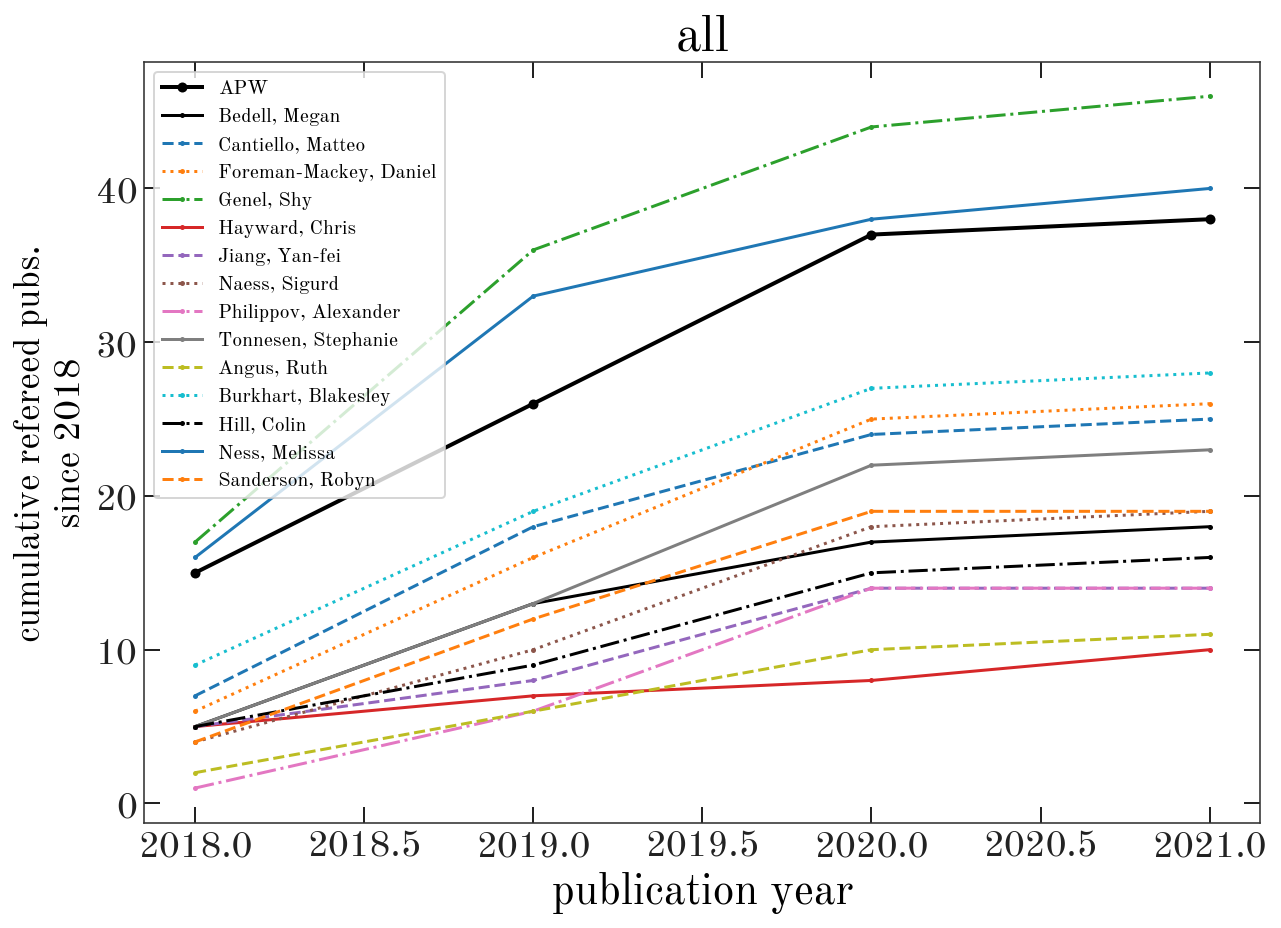

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.plot(years, np.cumsum(data['all'].T, axis=0)[:, 0], 
         marker='o', color='k', lw=2, label='APW')

default_cycler = cycler(linestyle=['-', '--', ':', '-.'])()
for i in range(1, len(all_papers)):
    plt.plot(years, np.cumsum(data['all'].T, axis=0)[:, i], 
             label=list(all_papers.keys())[i-1],
             **next(default_cycler))
plt.legend()
plt.xlabel('publication year')
plt.ylabel('cumulative refereed pubs.\nsince 2018', fontsize=18)
fig.set_facecolor('w')
ax.set_title('all', fontsize=26)

Text(0.5, 1.0, 'first author')

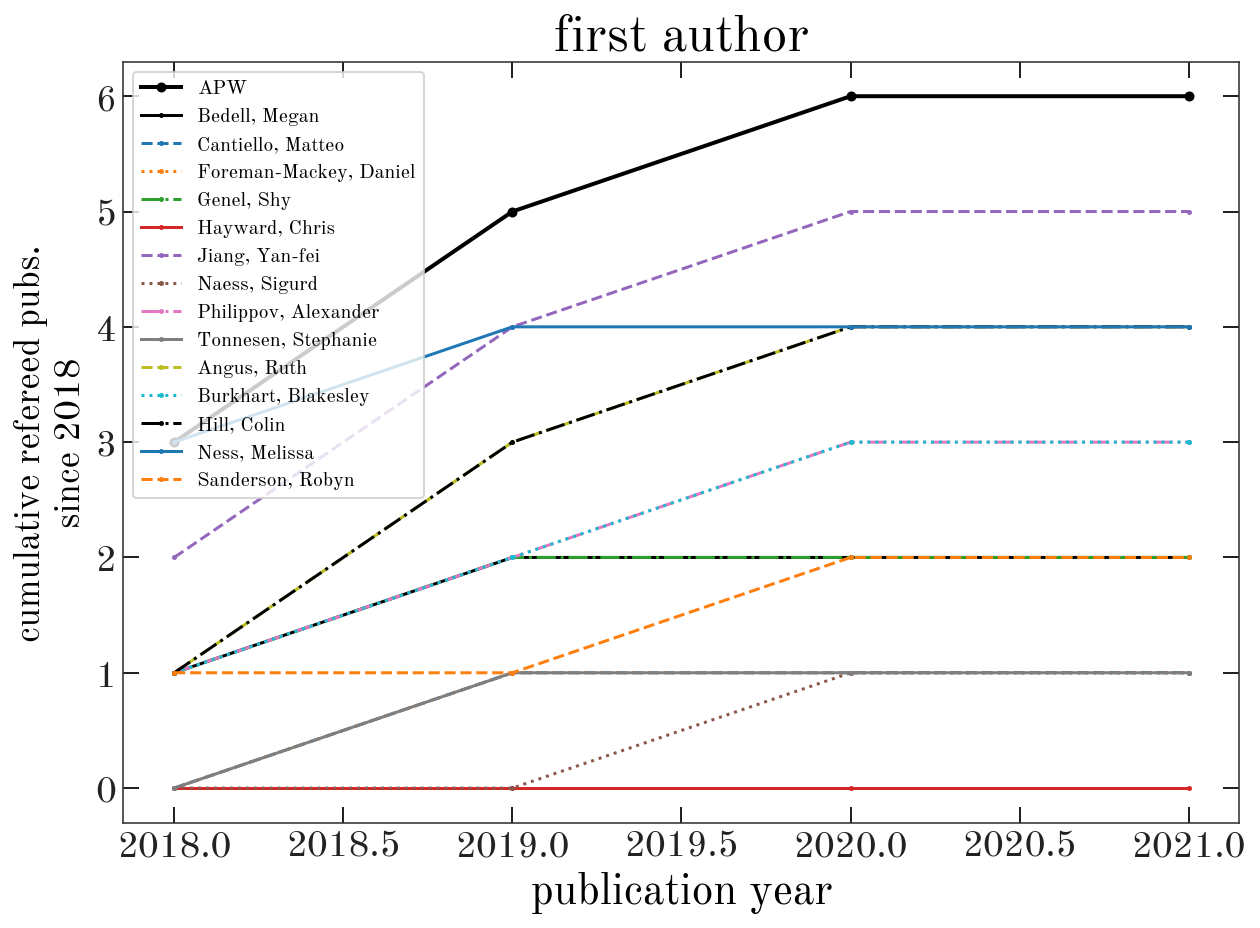

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

plt.plot(years, np.cumsum(data['first'].T, axis=0)[:, 0], 
         marker='o', color='k', lw=2, label='APW')

default_cycler = cycler(linestyle=['-', '--', ':', '-.'])()
for i in range(1, len(all_papers)):
    plt.plot(years, np.cumsum(data['first'].T, axis=0)[:, i], 
             label=list(all_papers.keys())[i-1],
             **next(default_cycler))
    
plt.legend()
plt.xlabel('publication year')
plt.ylabel('cumulative refereed pubs.\nsince 2018', fontsize=18)
fig.set_facecolor('w')
ax.set_title('first author', fontsize=26)

Text(0.5, 1.0, 'co-author, but top 5 authors')

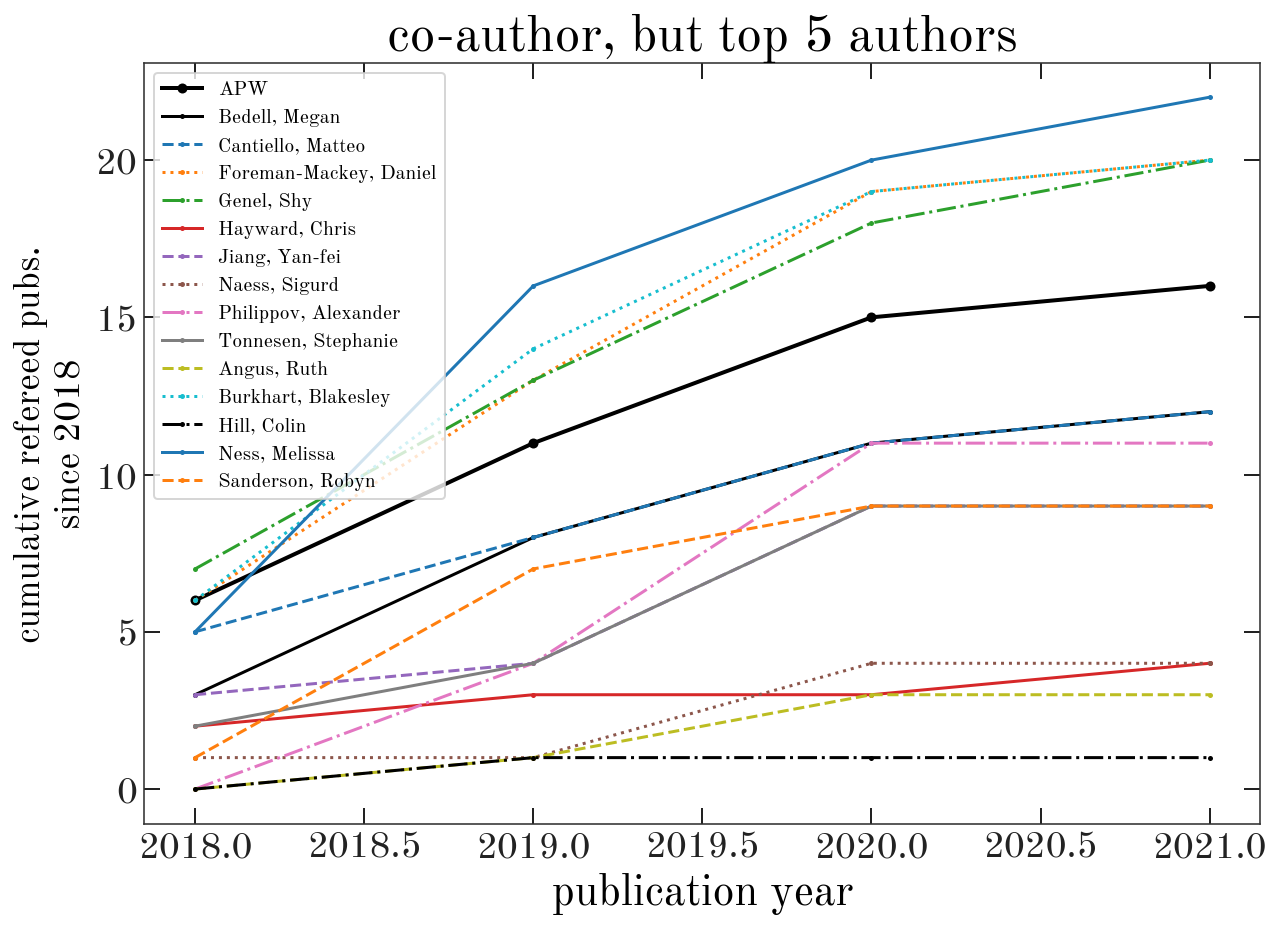

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

plt.plot(years, np.cumsum(data['nth'].T, axis=0)[:, 0], 
         marker='o', color='k', lw=2, label='APW')

default_cycler = cycler(linestyle=['-', '--', ':', '-.'])()
for i in range(1, len(all_papers)):
    plt.plot(years, np.cumsum(data['nth'].T, axis=0)[:, i], 
             label=list(all_papers.keys())[i-1],
             **next(default_cycler))

plt.legend()
plt.xlabel('publication year')
plt.ylabel('cumulative refereed pubs.\nsince 2018', fontsize=18)
fig.set_facecolor('w')
ax.set_title('co-author, but top 5 authors', fontsize=26)

Text(0.5, 1.0, 'co-author, any position')

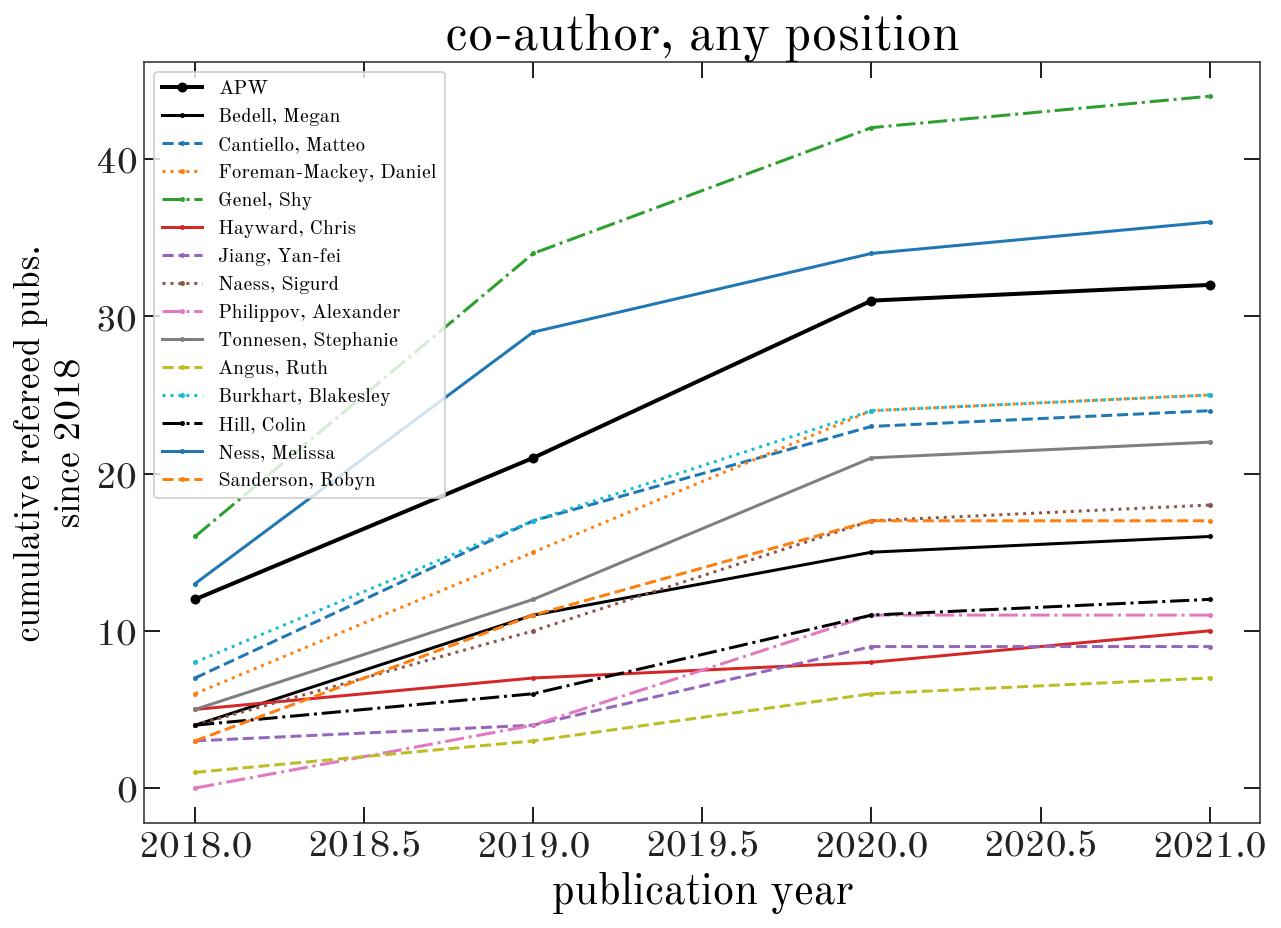

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.plot(years, np.cumsum((data['any'] + data['nth']).T, axis=0)[:, 0], 
         marker='o', color='k', lw=2, label='APW')

default_cycler = cycler(linestyle=['-', '--', ':', '-.'])()
for i in range(1, len(all_papers)):
    plt.plot(years, np.cumsum((data['any'] + data['nth']).T, axis=0)[:, i], 
             label=list(all_papers.keys())[i-1],
             **next(default_cycler))

plt.legend()
plt.xlabel('publication year')
plt.ylabel('cumulative refereed pubs.\nsince 2018', fontsize=18)
fig.set_facecolor('w')
ax.set_title('co-author, any position', fontsize=26)

---

In [103]:
persons

array(['Bedell, Megan', 'Cantiello, Matteo', 'Foreman-Mackey, Daniel',
       'Genel, Shy', 'Hayward, Chris', 'Jiang, Yan-fei', 'Naess, Sigurd',
       'Philippov, Alexander', 'Tonnesen, Stephanie', 'Angus, Ruth',
       'Burkhart, Blakesley', 'Hill, Colin', 'Ness, Melissa',
       'Sanderson, Robyn', 'Van Tilburg, Ken'], dtype='<U22')

In [117]:
print('Total number of citations for papers published since 2018')
print('(any author position)')

persons = np.array(list(all_papers.keys()))
print('Price-Whelan, Adrian', citation_data['all'][0].sum().astype(int), '\n')
citations_tmp = citation_data['all'][1:].sum(axis=1).astype(int)
for idx in citations_tmp.argsort()[::-1]:
    print(persons[idx], citations_tmp[idx])

Total number of citations for papers published since 2018
(any author position)
Price-Whelan, Adrian 3099 

Genel, Shy 3783
Ness, Melissa 1594
Sanderson, Robyn 797
Cantiello, Matteo 699
Foreman-Mackey, Daniel 696
Naess, Sigurd 682
Burkhart, Blakesley 378
Bedell, Megan 349
Jiang, Yan-fei 322
Hayward, Chris 313
Tonnesen, Stephanie 297
Hill, Colin 275
Philippov, Alexander 248
Van Tilburg, Ken 152
Angus, Ruth 146


In [116]:
print('Total number of citations for papers published since 2018')
print('(first author)')

persons = np.array(list(all_papers.keys()))
print('Price-Whelan, Adrian', citation_data['first'][0].sum().astype(int), '\n')
citations_tmp = citation_data['first'][1:].sum(axis=1).astype(int)
for idx in citations_tmp.argsort()[::-1]:
    print(persons[idx], citations_tmp[idx])

Total number of citations for papers published since 2018
(first author)
Price-Whelan, Adrian 689 

Jiang, Yan-fei 190
Genel, Shy 136
Angus, Ruth 110
Philippov, Alexander 103
Bedell, Megan 82
Ness, Melissa 77
Sanderson, Robyn 63
Burkhart, Blakesley 59
Van Tilburg, Ken 33
Foreman-Mackey, Daniel 33
Cantiello, Matteo 22
Hill, Colin 17
Naess, Sigurd 17
Tonnesen, Stephanie 8
Hayward, Chris 0


In [118]:
print('Total number of citations for papers published since 2018')
print('(2nd – 5th author)')

persons = np.array(list(all_papers.keys()))
print('Price-Whelan, Adrian', citation_data['nth'][0].sum().astype(int), '\n')
citations_tmp = citation_data['nth'][1:].sum(axis=1).astype(int)
for idx in citations_tmp.argsort()[::-1]:
    print(persons[idx], citations_tmp[idx])

Total number of citations for papers published since 2018
(2nd – 5th author)
Price-Whelan, Adrian 1844 

Genel, Shy 1116
Foreman-Mackey, Daniel 537
Ness, Melissa 378
Cantiello, Matteo 333
Burkhart, Blakesley 250
Hayward, Chris 203
Bedell, Megan 203
Sanderson, Robyn 177
Philippov, Alexander 145
Jiang, Yan-fei 132
Tonnesen, Stephanie 100
Naess, Sigurd 79
Van Tilburg, Ken 75
Angus, Ruth 18
Hill, Colin 13


In [120]:
print('Total number of citations for papers published since 2018')
print('(1st – 5th author)')

persons = np.array(list(all_papers.keys()))
print('Price-Whelan, Adrian', (citation_data['nth'][0] + citation_data['first'][0]).sum().astype(int), '\n')
citations_tmp = (citation_data['nth'] + citation_data['first'])[1:].sum(axis=1).astype(int)
for idx in citations_tmp.argsort()[::-1]:
    print(persons[idx], citations_tmp[idx])

Total number of citations for papers published since 2018
(1st – 5th author)
Price-Whelan, Adrian 2533 

Genel, Shy 1252
Foreman-Mackey, Daniel 570
Ness, Melissa 455
Cantiello, Matteo 355
Jiang, Yan-fei 322
Burkhart, Blakesley 309
Bedell, Megan 285
Philippov, Alexander 248
Sanderson, Robyn 240
Hayward, Chris 203
Angus, Ruth 128
Van Tilburg, Ken 108
Tonnesen, Stephanie 108
Naess, Sigurd 96
Hill, Colin 30
